In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
%matplotlib inline

from gEconpy.classes.model import gEconModel
from gEconpy.classes.transformers import IntervalTransformer
from gEconpy import compile_to_statsmodels


import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.gp_plotting import plot_sm_results

import numpy as np
import pandas as pd

import os

from config import plt_config
plt.rcParams.update(plt_config)

load model

In [25]:
from config import mod5_params
mod = gEconModel(os.path.join(MODEL_DIR, 'gEconpy_mod5_nk.gcn'), verbose=True)
plot_vars = ['Y', 'C', 'L', 'w', 'r', 'pi']

Model Building Complete.
Found:
	19 equations
	19 variables
	1 stochastic shock
		 0 / 1 has a defined prior. 
	8 parameters
		 0 / 8 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [26]:
mod.blocks

{'TECHNOLOGY_SHOCKS': <gEconpy.classes.block.Block at 0x1a47e3ef100>,
 'HOUSEHOLD': <gEconpy.classes.block.Block at 0x1a47f9f3370>,
 'FIRM': <gEconpy.classes.block.Block at 0x1a47fce19a0>,
 'PRICE_SETTING': <gEconpy.classes.block.Block at 0x1a47f812eb0>,
 'EQUILIBRIUM': <gEconpy.classes.block.Block at 0x1a47ddb7160>}

In [27]:
mod.variables

[A_t,
 C_t,
 I_t,
 K_t,
 L_t,
 MC_t,
 P_hat_t,
 P_t,
 Pi_t,
 Q_t,
 TC_t,
 U_t,
 Y_t,
 g1_t,
 lambda_t,
 pi_t,
 q_t,
 r_t,
 w_t]

In [28]:
# assign parameters
# mod.free_param_dict.update(mod6_params)
mod.free_param_dict

{'Theta': 0.75,
 'alpha': 0.35,
 'beta': 0.985,
 'delta': 0.02,
 'psi': 8.0,
 'rho_A': 0.95,
 'sigma_C': 2.0,
 'sigma_L': 1.5}

Investigate priors

Solve

In [29]:
%time mod.steady_state()

Steady state found! Sum of squared residuals is 1.138209113899232e-18
CPU times: total: 2.28 s
Wall time: 2.74 s


In [30]:
# steady state values
mod.print_steady_state()

A_ss               1.000
C_ss               0.779
I_ss               0.037
K_ss               1.854
L_ss               0.525
MC_ss              0.421
P_hat_ss           1.842
P_ss               1.842
Pi_ss              1.160
Q_ss               1.842
TC_ss             -0.344
U_ss             -90.856
Y_ss               0.817
g1_ss              1.612
lambda_ss          0.893
pi_ss              1.000
q_ss               1.646
r_ss               0.065
w_ss               0.426


In [31]:
mod.solve_model(solver="gensys")

[0, 1, 0]
Norm of deterministic part: 1.025202778
Norm of stochastic part:    1.025202778


In [32]:
mod.check_bk_condition()
;

Model solution has 6 eigenvalues greater than one in modulus and 4 forward-looking variables.
Blanchard-Kahn condition is satisfied.


''

In [33]:
# # policy matrix
# for name, policy_matrix in zip(["T", "R"], [round(mod.T, 5), round(mod.R, 5)]):
#     print(name.center(10).center(50, "="))
#     print(policy_matrix.to_string())

Model stats

''

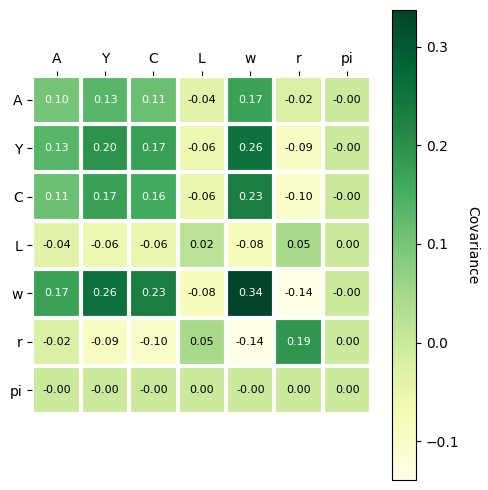

In [34]:
scov = mod.compute_stationary_covariance_matrix()
gp.plot_covariance_matrix(scov, plot_vars,
                          figsize=(5,5))
;

''

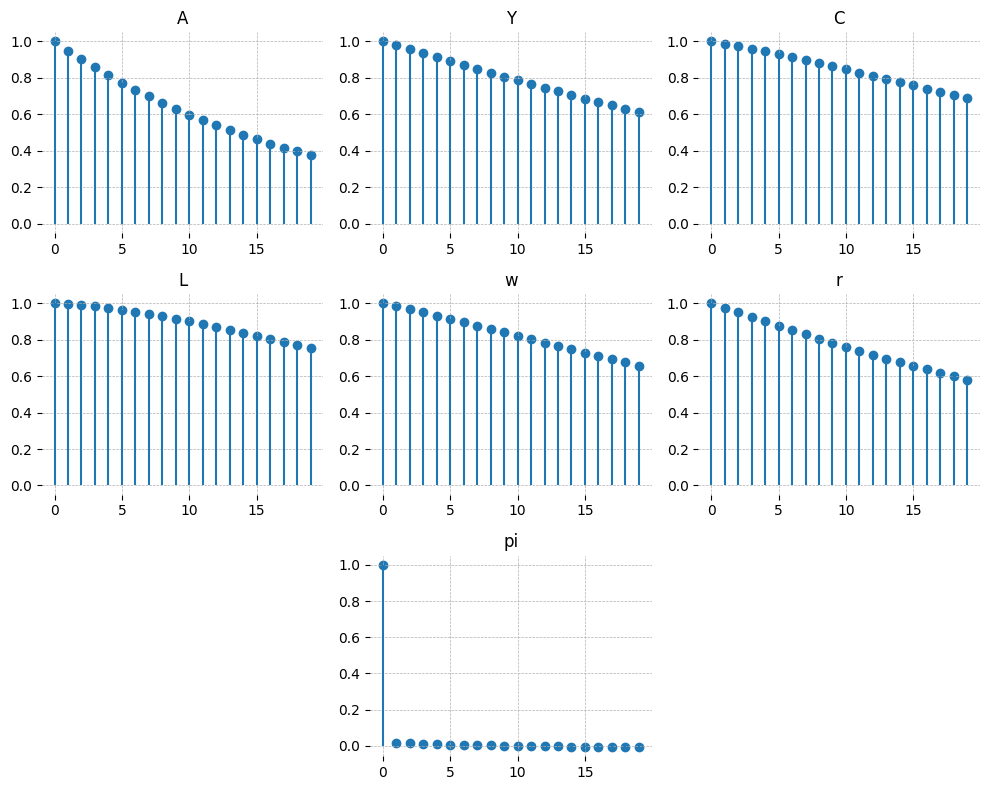

In [35]:
acorr = mod.compute_autocorrelation_matrix(n_lags=20)
gp.plot_acf(acorr, plot_vars, n_cols=3, figsize=(10, 8))
;

IRF

In [36]:
irf = mod.impulse_response_function(simulation_length=20, shock_size=1.0)
_irf = irf.copy().unstack().loc[:, "epsilon_A"].unstack()

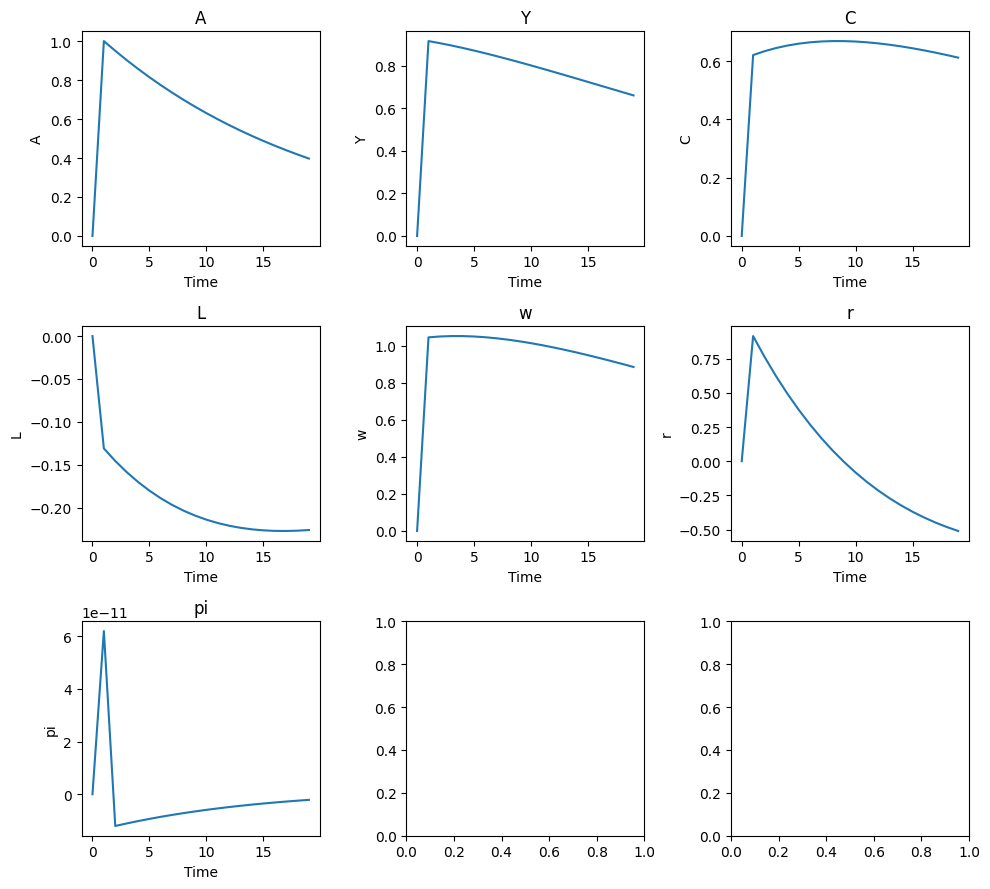

In [37]:
plot_dfs(_irf[plot_vars], sns.lineplot, figsize=(10, 3))

Estimation

In [49]:
from config import recession_dict
df = pd.read_csv(os.path.join(DATA_DIR, 'prepro_data.csv'), index_col='date').drop('Unnamed: 0', axis=1)
df.index = pd.to_datetime(df.index)
df = df.asfreq('QS')

In [50]:
df = df.rename(columns={'pi_s': 'pi'}).drop(['pi_c', 'Ix', 'Zx'], axis=1)
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

In [63]:
StatsMod = compile_to_statsmodels(mod)

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
        'Y':0.01
}

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
}
mod_stats = StatsMod(train[["Y"]],
                 param_start_dict = param_start_dict,
                  shock_start_dict = shock_start_dict,
                  noise_start_dict = noise_start_dict,
                  param_transforms = param_transforms,
                  shock_transforms=None, 
                  noise_transforms=None, 
                  initialization='stationary')

In [64]:
%%capture
# basinhopping as algorithm, mixes different approaches 
mod_res = mod_stats.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=500)

basinhopping step 0: f 18867.9
basinhopping step 1: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 2: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 3: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 4: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 5: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 6: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 7: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 8: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 9: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 10: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 11: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 12: f 18867.9 trial_f 18867.9 accepted 1  lowest_f 18867.9
basinhopping step 13: f 18867.9 trial_f 18867.9 accept

In [65]:
mod_res.summary()

C:\Users\LukasGrahl\Documents\GIT\memoire1\env_memoire1\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2979: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                   53
Model:                      DSGEModel   Log Likelihood                 -28.389
Date:                Mon, 13 Feb 2023   AIC                             62.779
Time:                        13:12:51   BIC                             68.690
Sample:                    04-01-2006   HQIC                            65.052
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.8500         -0       -inf      0.000       0.850       0.850
sigma2.epsilon_A     0.5000         -0       -inf      0.000       0.500       0.500
sigma2.Y             0.0100         -0       -inf      0.000       0.010       0.010
===================================================================================
Ljung-Box (L1) (Q):                   9.14   Jarque-Bera (JB):                51.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [67]:
mod_res.data.ynames

'Y'

In [68]:
mod_res.states.predicted.head()

,A,C,I,K,L,MC,P_hat,P,Pi,Q,TC,U,Y,g1,lambda,pi,q,r,w
2006-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
2006-07-01,-0.008011,-0.010833,-0.038229,-0.019129,0.003835,7.673856e-13,6.870373e-13,8.539094e-13,-0.012077,9.883750e-13,-0.012077,0.004291,-0.012077,8.539119e-13,0.021666,5.571598e-14,0.021666,0.006662,-0.015913
2006-10-01,-0.004394,-0.008632,-0.012445,-0.018757,0.003383,9.505641e-13,9.205404e-13,9.443759e-13,-0.008805,1.160653e-12,-0.008805,0.003106,-0.008805,9.443777e-13,0.017264,8.023706e-15,0.017264,0.010081,-0.012188
2007-01-01,0.003010,-0.003854,0.039464,-0.017158,0.002329,1.271767e-12,1.343320e-12,1.081255e-12,-0.001886,1.450526e-12,-0.001886,0.000605,-0.001886,1.081255e-12,0.007707,-8.730617e-14,0.007707,0.016427,-0.004215
2007-04-01,0.010542,0.001365,0.091133,-0.014429,0.001085,1.527905e-12,1.700915e-12,1.157038e-12,0.005443,1.662944e-12,0.005443,-0.002040,0.005443,1.157037e-12,-0.002731,-1.812778e-13,-0.002731,0.022026,0.004358


In [74]:
# mu for loc.[:, X] column
getattr(mod_res.states, 'predicted_cov').head()

# sigma for loc.[X, X] diagonal
getattr(mod_res.states, 'predicted_cov').head()

,,A,C,I,K,L,MC,P_hat,P,Pi,Q,TC,U,Y,g1,lambda,pi,q,r,w
A,2006-04-01,5.128205,5.643219,28.560315,8.278352,-1.840909,-7.752221e-11,-1.788604e-10,-2.675525e-10,6.684166,-3.358369e-10,6.684166,-2.385306,6.684166,-2.714287e-10,-11.286438,-8.945804e-12,-11.286438,-1.180268,8.525075
C,2006-04-01,5.643219,7.841165,26.261215,14.121443,-2.801794,-4.829230e-10,-5.265018e-10,-6.073137e-10,8.677846,-7.446201e-10,8.677846,-3.081280,8.677846,-6.097229e-10,-15.682330,-1.416928e-11,-15.682330,-5.195847,11.479639
I,2006-04-01,28.560315,26.261215,175.428981,30.228192,-7.794269,8.278248e-10,4.823702e-11,-4.988914e-10,33.036759,-6.822610e-10,33.036759,-11.838536,33.036759,-5.263598e-10,-52.522430,-3.612065e-11,-52.522430,5.771848,40.831027
K,2006-04-01,8.278352,14.121443,30.228192,28.761517,-5.355935,-1.346773e-09,-1.301633e-09,-1.393230e-09,14.853049,-1.694453e-09,14.853049,-5.252858,14.853049,-1.393783e-09,-28.242887,-2.772932e-11,-28.242887,-13.878536,20.208984
L,2006-04-01,-1.840909,-2.801794,-7.794269,-5.355935,1.030010,2.169841e-10,2.210431e-10,2.448954e-10,-3.028563,2.989810e-10,-3.028563,1.073402,-3.028563,2.454038e-10,5.603587,5.268880e-12,5.603587,2.277610,-4.058573


In [ ]:
upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

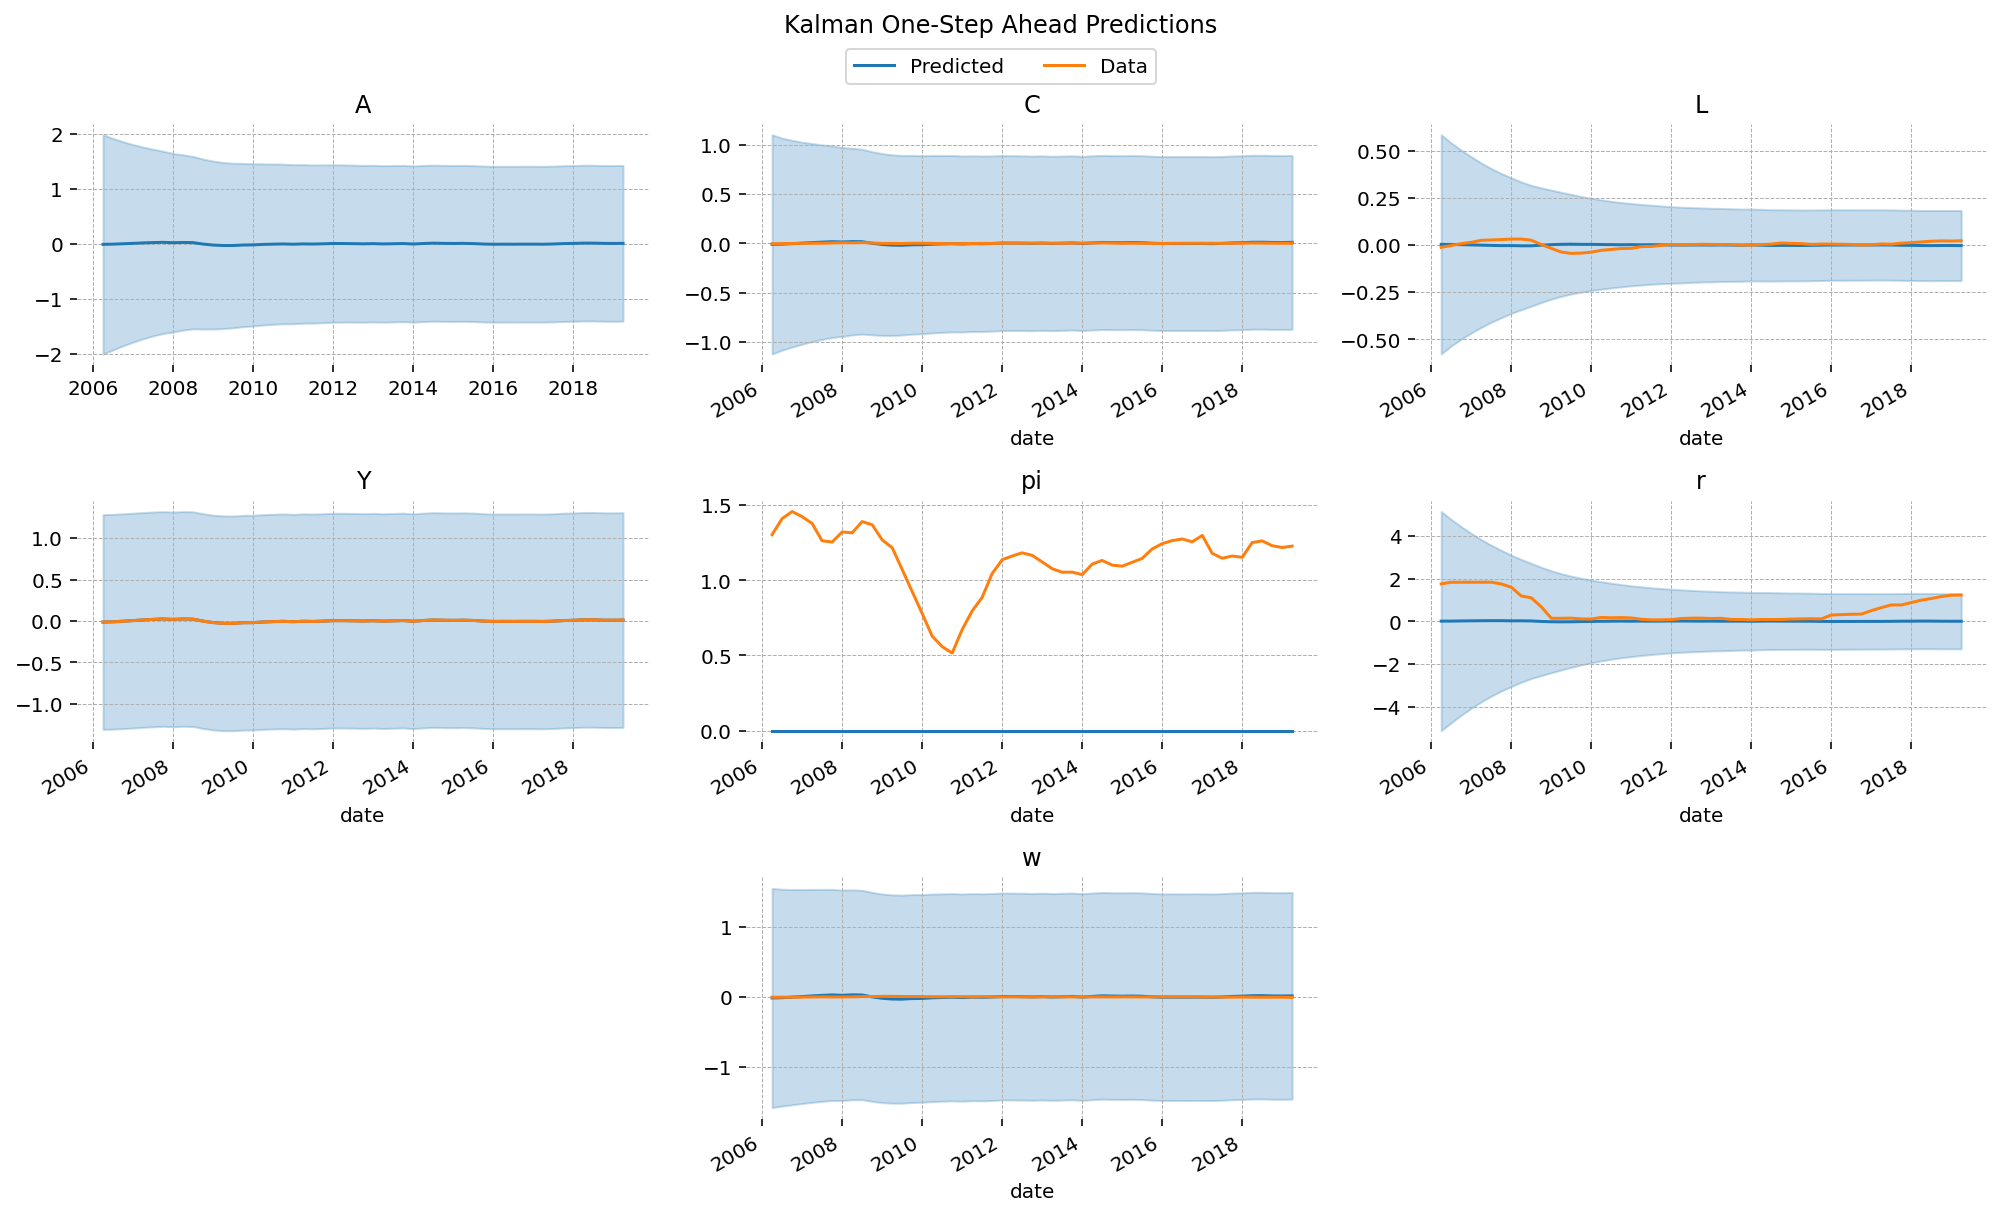

In [80]:
plot_sm_results(mod_res, train, var_names=plot_vars)